In [1226]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import Keys, ActionChains
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException 
import time
import requests 
import re
import numpy as np

import pickle
import json

import pandas as pd

from itables import init_notebook_mode
from itables import show
import uuid

import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import numpy as np
from matplotlib.ticker import PercentFormatter

## Query preparation

In [998]:
def normalize(text):
    #Make the query lower case as users tend to care less about capitalization when searching
    text = text.lower()
    
    #Remove "the " if it's at the beginning, as people most likely won't type it
    text = re.sub(r"^the ","", text)
    
    #Replace dashes with spaces, as it's more common for mobile typing
    text = text.replace("-"," ",)
    
    #Remove special characters that people tend to not type in
    text = text.replace("'","")
    text = text.replace(".","")
    text = text.replace("’","")
    text = text.replace("/","")
    text = text.replace(":","")
    
    #Remove words in parenthesis
    text = re.sub(r"\(.*\)","", text)
    return text

In [1337]:
# Base query based on output from chatGPT

query_df = pd.read_csv('chain_names.txt',sep='\t')
query_df.drop_duplicates(subset=['Chain name'],inplace=True)

query_df['Variations'] = query_df['Variations'].str.split(',')
    
#Make the query lower case as users tend to care less about capitalization when searching
query_df['query'] = query_df['Chain name'].map(normalize)

query_df.fillna("",inplace=True)

category_count = query_df.groupby('Category')['Chain name'].count().to_frame(name='count').reset_index()
query_df = query_df.merge(category_count, on='Category')
query_df['Category_n'] = query_df['Category'] +' ('+ query_df['count'].astype(str)+')'
query_df.drop(columns=['count'],axis=1,inplace=True)

## Data retrieval

In [7]:
#autocomplete_df will be the master dataframe for all engines
autocomplete_df = pd.DataFrame(columns=['engine','query','num_char','pos','type','text'])

#Longitude, latitude used
LONGITUDE = -122.162380814
LATITUDE = 37.87809491032992

### Google

In [9]:
# Few initialization
GOOGLE_KEY = ''

# Base URL for Google Places Autocomplete
GOOGLE_URL = 'https://places.googleapis.com/v1/places:autocomplete'

GOOGLE_SESSION_TOKEN = str(uuid.uuid4())
print(f"Google session token: {GOOGLE_SESSION_TOKEN}")

#Header for request
headers = {
#      'Authorization' : f"Bearer {GOOGLE_KEY}",
      'Accept' : 'application/json',
      'Content-Type' : 'application/json',
      'X-Goog-Api-Key' : GOOGLE_KEY
     }


Google session token: 4cc4a526-fe05-44b8-9d99-6dab2420ebaf


In [10]:
# Dataframe to store the API results
google_df = pd.DataFrame(columns=['query','num_char','raw_output'])

#Iterate through queries
for index, row in query_df.iloc[:,:].iterrows():

    #Make 5 API calls for each query, starting from first 2 characters, up to 6
    for num_char in range(2,7):    
        query = row['query']
        new_row = pd.Series({'query':row['query'], 'num_char':num_char}).to_frame().T

        data_input = {'input': query[:num_char],
                      'includeQueryPredictions': 'true',
                      "locationBias":{"circle":{"center":{"latitude":LATITUDE,"longitude":LONGITUDE}}}}
        
        response = requests.post(GOOGLE_URL, headers=headers, data=json.dumps(data_input))

        
        if response.status_code == 200:
            new_row['raw_output'] = response.text
        else:
            new_row['raw_output'] = str(response.status_code) + '\n' + response.text
        google_df = pd.concat([google_df, new_row],ignore_index=True,axis=0)
    

In [11]:
#Export to csv
google_df.to_csv('google_results.csv')

In [12]:
#Make dataframe to store the parsed results. Eventually it will be merged to autocomplete_df
autocomplete_df_g = pd.DataFrame(columns=autocomplete_df.columns)

for index, row in google_df.iterrows():
    predictions = json.loads(row['raw_output'])['suggestions']
    for prediction, pos in zip(predictions,range(0,len(predictions))):
        if 'placePrediction' in prediction:
            predict_type = 'place'
            text = prediction['placePrediction']['structuredFormat']['mainText']['text']
        elif 'queryPrediction' in prediction:
            predict_type = 'query'
            text = prediction['queryPrediction']['structuredFormat']['mainText']['text']
        else:
            predict_type = 'N/A'
        new_row = {
            'engine':'google',
            'query':row['query'],
            'num_char':row['num_char'],
            'pos':pos+1,
            'type':predict_type,
            'text':text}
        autocomplete_df_g = pd.concat([autocomplete_df_g,pd.Series(new_row).to_frame().T],axis=0, ignore_index=True)
        

In [13]:
autocomplete_df_g

,engine,query,num_char,pos,type,text
0,google,76,2,0,query,76
1,google,76,2,1,query,76 Oakland Smog
2,google,76,2,2,query,Cantina 76
3,google,76,2,3,place,7677 Oakport Street
4,google,76,2,4,place,76 La Cuesta Road
...,...,...,...,...,...,...
3545,google,zara,6,0,query,Zara
3546,google,zara,6,1,query,ZARA Home
3547,google,zara,6,2,query,Zarraffa's Coffee
3548,google,zara,6,3,place,Zaragoza


### Mapbox

In [15]:
#Few initialization

MAPBOX_URL  = "https://api.mapbox.com/search/searchbox/v1/suggest"

MAPBOX_API_KEY = ''
MAPBOX_SESSION_TOKEN = str(uuid.uuid4())
print(f"Mapbox session token: {MAPBOX_SESSION_TOKEN}")



Mapbox session token: 56513a75-d345-4a5a-be24-d34642416640


In [16]:
mapbox_df = pd.DataFrame(columns=['query','num_char','raw_output'])

params = {
    "language": "en",
    "proximity": f"{LONGITUDE},{LATITUDE}",
    "session_token": MAPBOX_SESSION_TOKEN,
    "access_token": MAPBOX_API_KEY
}

#Iterate through queries
for index, row in query_df.iloc[:,:].iterrows():
    
    #Make 5 API calls for each query, starting from first 2 characters, up to 6
    for num_char in range(2,7):  
        query = {'q': row['query'][:num_char]}
        new_row = pd.Series({'query':row['query'], 'num_char':num_char}).to_frame().T
        
        response = requests.get(MAPBOX_URL, params=(params | query))

        if response.status_code == 200:
            new_row['raw_output'] = response.text
        else:
            new_row['raw_output'] = str(response.status_code) + '\n' + response.text
        mapbox_df = pd.concat([mapbox_df, new_row],ignore_index=True,axis=0)

In [17]:
#Make dataframe to store the parsed results. Eventually it will be merged to autocomplete_df
autocomplete_df_m = pd.DataFrame(columns=autocomplete_df.columns)

for index, row in mapbox_df.iterrows():
    predictions = json.loads(row['raw_output'])['suggestions']
    for prediction, pos in zip(predictions,range(0,len(predictions))):
        new_row = {
            'engine':'mapbox',
            'query':row['query'],
            'num_char':row['num_char'],
            'pos':pos + 1,
            'type':prediction['feature_type'],
            'text':prediction['name']}
        autocomplete_df_m = pd.concat([autocomplete_df_m,pd.Series(new_row).to_frame().T],axis=0, ignore_index=True)
        

In [18]:
mapbox_df.to_csv('mapbox_results.csv')

In [19]:
autocomplete_df_m

,engine,query,num_char,pos,type,text
0,mapbox,76,2,1,brand,76
1,mapbox,76,2,2,poi,76
2,mapbox,76,2,3,poi,76
3,mapbox,76,2,4,poi,76
4,mapbox,76,2,5,poi,76
...,...,...,...,...,...,...
3537,mapbox,zara,6,1,brand,Zara
3538,mapbox,zara,6,2,poi,ZARA
3539,mapbox,zara,6,3,poi,ZARA
3540,mapbox,zara,6,4,poi,ZARA


### HERE

In [21]:
HERE_URL  = "https://autosuggest.search.hereapi.com/v1/autosuggest"
HERE_API_KEY = ''



In [22]:
here_df = pd.DataFrame(columns=['query','num_char','raw_output'])
params = {
    "lang": "en",
    "limit": "5",
    "at": f"{LATITUDE},{LONGITUDE}",
    "apiKey": HERE_API_KEY
}

#Iterate through queries
for index, row in query_df.iloc[:,:].iterrows():
    #Make 5 API calls for each query, starting from first 2 characters, up to 6
    for num_char in range(2,7):  
        query = {'q': row['query'][:num_char]}
        new_row = pd.Series({'query':row['query'], 'num_char':num_char}).to_frame().T
        
        response = requests.get(HERE_URL, params=(params | query))

        if response.status_code == 200:
            new_row['raw_output'] = response.text
        else:
            new_row['raw_output'] = str(response.status_code) + '\n' + response.text
        here_df = pd.concat([here_df, new_row],ignore_index=True,axis=0)

In [23]:
here_df.at[0,'raw_output']

'{"items":[{"title":"76 Evergreen Dr, Orinda, CA 94563-3115, United States","id":"here:af:streetsection:NTG2SD2swrMWYktJcWDQRC:CgcIBCDnpLs7EAEaAjc2","resultType":"houseNumber","houseNumberType":"PA","address":{"label":"76 Evergreen Dr, Orinda, CA 94563-3115, United States"},"position":{"lat":37.87678,"lng":-122.17135},"access":[{"lat":37.87743,"lng":-122.17119}],"distance":801,"mapView":{"west":-122.1738,"south":37.87724,"east":-122.16951,"north":37.87928},"highlights":{"title":[{"start":0,"end":2}],"address":{"label":[{"start":0,"end":2}]}}},{"title":"76 Silverwood Dr, Lafayette, CA 94549-3329, United States","id":"here:af:streetsection:1B7w.KcRMa1aAAc4PYwYvB:CgcIBCCIqdwREAEaAjc2","resultType":"houseNumber","houseNumberType":"PA","address":{"label":"76 Silverwood Dr, Lafayette, CA 94549-3329, United States"},"position":{"lat":37.88588,"lng":-122.16226},"access":[{"lat":37.88527,"lng":-122.16233}],"distance":866,"mapView":{"west":-122.16501,"south":37.88462,"east":-122.16064,"north":37

In [24]:
#Make dataframe to store the parsed results. Eventually it will be merged to autocomplete_df
autocomplete_df_h = pd.DataFrame(columns=autocomplete_df.columns)

for index, row in here_df.iterrows():
    predictions = json.loads(row['raw_output'])['items']
    for prediction, pos in zip(predictions,range(0,len(predictions))):
        new_row = {
            'engine':'here',
            'query':row['query'],
            'num_char':row['num_char'],
            'pos':pos + 1,
            'type':prediction['resultType'],
            'text':prediction['title']}
        autocomplete_df_h = pd.concat([autocomplete_df_h,pd.Series(new_row).to_frame().T],axis=0, ignore_index=True)
        

## Analyze

In [1339]:
autocomplete_df = pd.concat([autocomplete_df_g,autocomplete_df_m,autocomplete_df_h], axis=0, ignore_index=True)

### Mark correct results

In [1341]:
show(autocomplete_df[['query','type','text']])

In [1342]:
autocomplete_df.to_csv('autocomplete_df.csv')

In [1343]:
def match_query(row):
    if (normalize(row['text']) == row['query']) or (normalize(row['text']) in [normalize(t) for t in row['Variations']]):
        return 1
    else:
        return 0
autocomplete_df = pd.concat([autocomplete_df_g,autocomplete_df_m,autocomplete_df_h], axis=0, ignore_index=True).reset_index()
    
autocomplete_df = autocomplete_df.merge(query_df[['query','Variations']], on='query')
autocomplete_df['text_match'] = autocomplete_df.apply(match_query, axis=1)
autocomplete_df['text_chain_match'] = autocomplete_df['text_match'] & autocomplete_df['type'].isin(['query','brand','chainQuery'])
autocomplete_df['text_chain_match'] = autocomplete_df['text_chain_match'].astype(int)
autocomplete_df.drop(columns=['Variations','index'],axis=1,inplace=True)


autocomplete_df['correct'] = autocomplete_df['text_match']
#autocomplete_df['correct'] = autocomplete_df['text_chain_match']

In [1344]:
show(autocomplete_df)

### Generate scores

Following metrics will be calculated per query:
   * __Coverage @ 2 keys TOP 3__ If the correct suggestions appears within top 3 results after first 2 letters of the query
   * __Coverage @ 3 keys TOP 3__ If the correct suggestions appears within top 3 results after first 3 letters of the query
   * __Coverage @ 5 keys TOP 3__ If the correct suggestions appears within top 3 results after first 5 letters of the query
   * __Mean Minimum keystrokes TOP 1 (MMK TOP1)__ - Minimum number of keystrokes/taps to get the chain query as the first suggestion
   * __Mean Minimum keystrokes TOP 3 (MMK TOP3)__ - Minimum number of keystrokes/taps to get the chain query within the first 3 suggestions
   * __Mean Minimum keystrokes TOP 5 (MMK TOP5)__ - Minimum number of keystrokes/taps to get the chain query within the 5 suggestions
   * __Mean Reciprocal Rank (MRR)__ - Measures the rank position of chain query across # of key strokes, discounted by reciprocal (1 / rank position)
   * __Mean log Reciprocal Rank (MLRR)__ - Similar to MRR except the discount is done using log reciprocal (1 / log(rank position))
   * __Mean keystroke savings @ 3 (MKS TOP3)__ - Number of keystrokes saved to get the chain query within the first 3 suggestions
   * __Mean keystroke savings @ 5 (MKS TOP5)__ - Number of keystrokes saved to get the chain query within the first 5 suggestions

In [1346]:
pivot_df = autocomplete_df.pivot(index=['engine','query','num_char'],columns=['pos'],values=['text','type','correct']).reset_index()
pivot_df

C:\Users\hiron\AppData\Local\Temp\ipykernel_30328\1347575007.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_df = autocomplete_df.pivot(index=['engine','query','num_char'],columns=['pos'],values=['text','type','correct']).reset_index()
C:\Users\hiron\AppData\Local\Temp\ipykernel_30328\1347575007.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_df = autocomplete_df.pivot(index=['engine','query','num_char'],columns=['pos'],values=['text','type','correct']).reset_index()


engine     query num_char          text                                \
pos                                         1                             2   
0     google  7 eleven        2      7-Eleven                 7 Brew Coffee   
1     google  7 eleven        3      7-Eleven                      7-Eleven   
2     google  7 eleven        4      7-Eleven                      7-Eleven   
3     google  7 eleven        5      7-Eleven                      7-Eleven   
4     google  7 eleven        6      7-Eleven                      7-Eleven   
...      ...       ...      ...           ...                           ...   
2095  mapbox      zara        2  South Africa                          Zara   
2096  mapbox      zara        3          Zara  zari joon child home daycare   
2097  mapbox      zara        4          Zara                          ZARA   
2098  mapbox      zara        5          Zara                          ZARA   
2099  mapbox      zara        6          Zara                          ZARA   

                                                               \
pos                                3                        4   
0                  7th Street Burger            7 Leaves Cafe   
1                           7-Eleven                 7-Eleven   
2                           7-Eleven                 7-Eleven   
3                           7-Eleven                 7-Eleven   
4                           7-Eleven                 7-Eleven   
...                              ...                      ...   
2095  Zalivsko območje San Francisca  Zachary's Chicago Pizza   
2096  Zareen's Restaurant & Catering           Zarc Recycling   
2097                            ZARA                     ZARA   
2098                            ZARA                     ZARA   
2099                            ZARA                     ZARA   

                                  type                              correct  \
pos                         5        1      2      3      4       5       1   
0        7th Heaven Cake Shop    query  query  query  query   query       1   
1                    7-Eleven    query  place  place  place   place       1   
2                    7-Eleven    query  place  place  place   place       1   
3                    7-Eleven    query  place  place  place   place       1   
4                    7-Eleven    query  place  place  place   place       1   
...                       ...      ...    ...    ...    ...     ...     ...   
2095  Zachary's Chicago Pizza  country  brand  place    poi     poi       0   
2096              Zara Avenue    brand    poi    poi    poi  street       1   
2097                     ZARA    brand    poi    poi    poi     poi       1   
2098                     ZARA    brand    poi    poi    poi     poi       1   
2099                     ZARA    brand    poi    poi    poi     poi       1   

                  
pos   2  3  4  5  
0     0  0  0  0  
1     1  1  1  1  
2     1  1  1  1  
3     1  1  1  1  
4     1  1  1  1  
...  .. .. .. ..  
2095  1  0  0  0  
2096  0  0  0  0  
2097  1  1  1  1  
2098  1  1  1  1  
2099  1  1  1  1  

[2100 rows x 18 columns]

In [1347]:
pivot_df.loc[(pivot_df['num_char']==3),['query','engine','correct']]

query  engine correct            
pos                                           1  2  3  4  5
1                      7 eleven  google       1  1  1  1  1
6                            76  google       1  0  0  0  0
11              99 ranch market  google       1  0  0  0  0
16          abercrombie & fitch  google       1  0  0  0  0
21    academy sports + outdoors  google       1  0  0  0  0
...                         ...     ...     ... .. .. .. ..
2076                     wendys  mapbox       1  1  0  0  1
2081                   west elm  mapbox       0  0  0  0  0
2086         whole foods market  mapbox       1  0  0  0  0
2091                winco foods  mapbox       0  0  0  0  0
2096                       zara  mapbox       1  0  0  0  0

[420 rows x 7 columns]

In [1348]:
def get_rr(row, use_log = False):
    if row[('correct',1)] == 1:
        return 1
    elif row[('correct',2)] == 1:
        return 1.0 / (math.log(2 + 1,2) if use_log else 2.0)
    elif row[('correct',3)] == 1:
        return 1.0 / (math.log(3 + 1,2) if use_log else 3.0)
    elif row[('correct',4)] == 1:
        return 1.0 / (math.log(4 + 1,2) if use_log else 4.0)
    elif row[('correct',5)] == 1:
        return 1.0 / (math.log(5 + 1,2) if use_log else 5.0) 
    else:
        return 0
        
def update_mk_nans(row,col):
    if ~np.isnan(row[col]):
        return row[col]
    elif len(row['query']) > 10.0:
        return 10.0
    else:
        return len(row['query'])
    
metric_df = query_df[['query','Category', 'Category_n']]
engines = pd.DataFrame({'engine':['google','mapbox','here']})
metric_df = metric_df.merge(engines,how='cross')

cov_top3 = autocomplete_df.loc[(autocomplete_df['pos'] <= 3) & autocomplete_df['num_char'].isin([2,3,5])]
cov_top3 = cov_top3.groupby(['engine','query','num_char'])['correct'].max().reset_index()
metric_df = metric_df.merge(cov_top3.loc[cov_top3['num_char'] == 2,['engine','query','correct']],on=['engine','query'],how='left')
metric_df.rename(columns={'correct':'cov_2_top3'},inplace=True)
metric_df = metric_df.merge(cov_top3.loc[cov_top3['num_char'] == 3,['engine','query','correct']],on=['engine','query'],how='left')
metric_df.rename(columns={'correct':'cov_3_top3'},inplace=True)
metric_df = metric_df.merge(cov_top3.loc[cov_top3['num_char'] == 5,['engine','query','correct']],on=['engine','query'],how='left')
metric_df.rename(columns={'correct':'cov_5_top3'},inplace=True)


mk_top1 = pivot_df.loc[(pivot_df[('correct',1)]==1),
                       ['engine','query','num_char']].groupby(['engine','query']).min()
mk_top1.columns = ['_'.join(filter(None, col)) for col in mk_top1.columns]
mk_top1.rename(columns={'num_char':'mk_top1'},inplace=True)
metric_df = metric_df.merge(mk_top1, on=['query','engine'],how='left')
metric_df['mk_top1'] = metric_df.apply(update_mk_nans,axis=1, col='mk_top1')


mk_top3 = pivot_df.loc[(pivot_df[('correct',1)]==1) | (pivot_df[('correct',2)]==1) | (pivot_df[('correct',3)]==1),
                       ['engine','query','num_char']].groupby(['engine','query']).min()
mk_top3.columns = ['_'.join(filter(None, col)) for col in mk_top3.columns]
mk_top3.rename(columns={'num_char':'mk_top3'},inplace=True)
metric_df = metric_df.merge(mk_top3, on=['query','engine'],how='left')
metric_df['mk_top3'] = metric_df.apply(update_mk_nans,axis=1, col='mk_top3')


mk_top5 = pivot_df.loc[(pivot_df[('correct',1)]==1) | (pivot_df[('correct',2)]==1) | (pivot_df[('correct',3)]==1)
                       | (pivot_df[('correct',4)]==1) | (pivot_df[('correct',5)]==1),
                       ['engine','query','num_char']].groupby(['engine','query']).min()
mk_top5.columns = ['_'.join(filter(None, col)) for col in mk_top5.columns]
mk_top5.rename(columns={'num_char':'mk_top5'},inplace=True)
metric_df = metric_df.merge(mk_top5, on=['query','engine'],how='left')
metric_df['mk_top5'] = metric_df.apply(update_mk_nans,axis=1, col='mk_top5')



pivot_df['rr'] = pivot_df.apply(get_rr,axis=1)
mrr = pivot_df.groupby(['query','engine'])['rr'].mean().to_frame().reset_index()
mrr.rename(columns={'rr':'mrr'},inplace=True)
metric_df = metric_df.merge(mrr, on=['query','engine'],how='left')



pivot_df['lrr'] = pivot_df.apply(get_rr,use_log=True,axis=1)
mrr = pivot_df.groupby(['query','engine'])['lrr'].mean().to_frame().reset_index()
mrr.rename(columns={'lrr':'mlrr'},inplace=True)
metric_df = metric_df.merge(mrr, on=['query','engine'],how='left')


show(metric_df)

C:\Users\hiron\AppData\Local\Temp\ipykernel_30328\580932084.py:38: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ['engine','query','num_char']].groupby(['engine','query']).min()
C:\Users\hiron\AppData\Local\Temp\ipykernel_30328\580932084.py:46: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ['engine','query','num_char']].groupby(['engine','query']).min()
C:\Users\hiron\AppData\Local\Temp\ipykernel_30328\580932084.py:55: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ['engine','query','num_char']].groupby(['engine','query']).min()


### Metric analysis & visualization

#### Overall

In [1351]:
metric_df.to_csv('metrics_df.csv')

In [1352]:
metric_df.groupby(['engine'])[['cov_2_top3','cov_3_top3','cov_5_top3','mk_top1','mk_top3','mk_top5', 'mrr','mlrr']].agg(['mean','std'])

cov_2_top3           cov_3_top3           cov_5_top3            \
             mean       std       mean       std       mean       std   
engine                                                                  
google   0.614286  0.488511   0.857143  0.351184   0.942857  0.232949   
here     0.078571  0.270035   0.357143  0.480878   0.714286  0.453376   
mapbox   0.257143  0.438628   0.471429  0.500975   0.785714  0.411799   

         mk_top1             mk_top3             mk_top5                 mrr  \
            mean       std      mean       std      mean       std      mean   
engine                                                                         
google  3.585714  2.094823  2.728571  1.350954  2.464286  1.034726  0.791429   
here    5.578571  2.655435  4.807143  2.472573  4.542857  2.376054  0.443024   
mapbox  4.771429  2.715113  4.228571  2.400069  4.078571  2.319972  0.546429   

                      mlrr            
             std      mean       std  
engine                                
google  0.245307  0.821277  0.221721  
here    0.292667  0.468865  0.292452  
mapbox  0.319861  0.567099  0.318340

In [1353]:
print("cov_3_top3 T-TEST")
print("Google VS Mapbox")
temp_df = metric_df.loc[metric_df['engine'].isin(['google','mapbox']),['engine','cov_3_top3']]
contingency_table = pd.crosstab(temp_df['engine'],temp_df['cov_3_top3'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

print("\nMapbox VS HERE")
temp_df = metric_df.loc[metric_df['engine'].isin(['mapbox','here']),['engine','cov_3_top3']]
contingency_table = pd.crosstab(temp_df['engine'],temp_df['cov_3_top3'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

print("\nmk_top3 T-TEST")
print("Google VS Mapbox")
t_stat, p_value = stats.ttest_ind(metric_df.loc[metric_df['engine']=='google','mk_top3'], metric_df.loc[metric_df['engine']=='mapbox','mk_top3'])
print(f"Two-sample t-test\nT-statistic: {t_stat}\nP-value: {p_value}")

print("\nMapbox VS HERE")
t_stat, p_value = stats.ttest_ind(metric_df.loc[metric_df['engine']=='mapbox','mk_top3'], metric_df.loc[metric_df['engine']=='here','mk_top3'])
print(f"Two-sample t-test\nT-statistic: {t_stat}\nP-value: {p_value}")


# Output the result


cov_3_top3 T-TEST
Google VS Mapbox
Chi-Square Statistic: 44.985129261038665
P-value: 1.9853641973474492e-11

Mapbox VS HERE
Chi-Square Statistic: 3.311606391925989
P-value: 0.06879221562157202

mk_top3 T-TEST
Google VS Mapbox
Two-sample t-test
T-statistic: -6.444153289373378
P-value: 5.110224199157883e-10

Mapbox VS HERE
Two-sample t-test
T-statistic: -1.9866595811509047
P-value: 0.047941717858802246


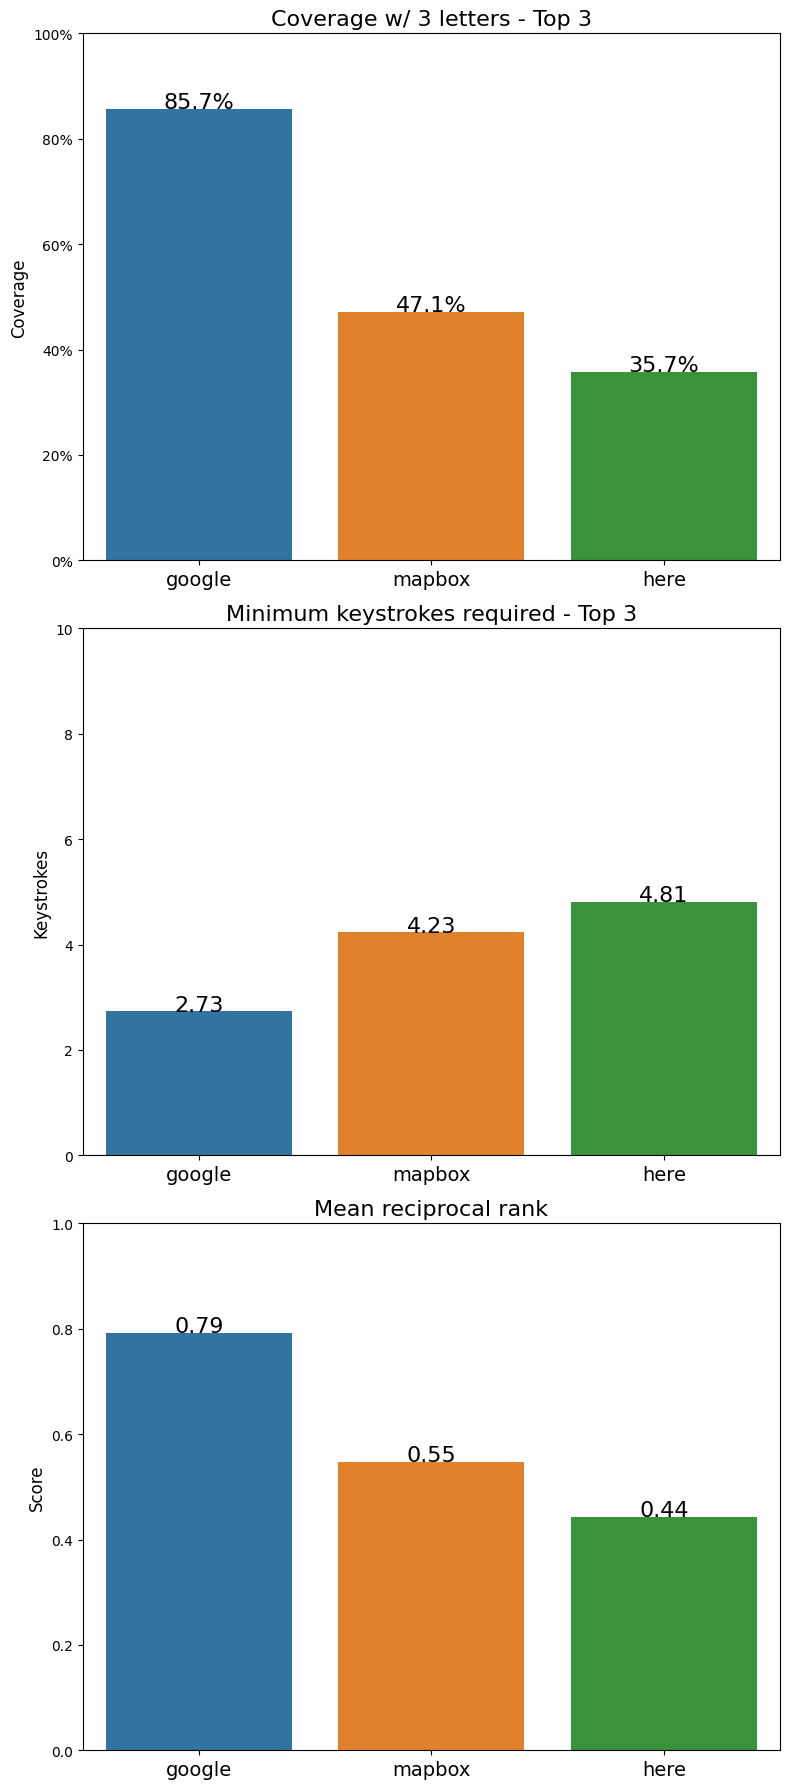

In [1354]:



fig, axes = plt.subplots(3, 1, figsize=(8, 18))

sns.barplot(x='engine', y='cov_3_top3', data=metric_df,ax=axes[0], errorbar=None)
# Add labels and title
axes[0].set_title('Coverage w/ 3 letters - Top 3', fontsize=16)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('Coverage', fontsize=12)
axes[0].set_ylim(0,1)
axes[0].yaxis.set_major_formatter(PercentFormatter(1))
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()*100:.1f}%',   # Text to annotate (value on top of the bar)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the label
                ha='center', va='center',  # Alignment
                xytext=(0, 5),             # Distance from the bar (5 points above the bar)
                textcoords='offset points',
                fontsize=16)# Specify that the offset is in points
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=14)

sns.barplot(x='engine', y='mk_top3', data=metric_df,ax=axes[1], errorbar=None)
# Add labels and title
axes[1].set_title('Minimum keystrokes required - Top 3', fontsize=16)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('Keystrokes', fontsize=12)
axes[1].set_ylim(0,10)

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.2f}',   # Text to annotate (value on top of the bar)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the label
                ha='center', va='center',  # Alignment
                xytext=(0, 5),             # Distance from the bar (5 points above the bar)
                textcoords='offset points',
                fontsize=16)# Specify that the offset is in points
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=14)
    


sns.barplot(x='engine', y='mrr', data=metric_df,ax=axes[2], errorbar=None)
# Add labels and title
axes[2].set_title('Mean reciprocal rank', fontsize=16)
axes[2].set_xlabel('', fontsize=12)
axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_ylim(0,1)

for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.2f}',   # Text to annotate (value on top of the bar)
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the label
                ha='center', va='center',  # Alignment
                xytext=(0, 5),             # Distance from the bar (5 points above the bar)
                textcoords='offset points',
                fontsize=16)# Specify that the offset is in points
axes[2].set_xticklabels(axes[1].get_xticklabels(), fontsize=14)

    
plt.tight_layout()
# Show the plot
plt.show()

#### By category

In [1356]:
metric_df.groupby(['Category_n','engine'])[['cov_2_top3','cov_3_top3','cov_5_top3','mk_top1','mk_top3','mk_top5', 'mrr','mlrr']].agg(['mean','std'])

cov_2_top3           cov_3_top3  \
                                               mean       std       mean   
Category_n                        engine                                   
Auto Parts & Service (4)          google   0.500000  0.577350   0.750000   
                                  here     0.000000  0.000000   0.250000   
                                  mapbox   0.500000  0.577350   1.000000   
Beauty & Cosmetics (4)            google   0.500000  0.577350   0.750000   
                                  here     0.000000  0.000000   0.250000   
                                  mapbox   0.250000  0.500000   0.750000   
Big-Box Retailers (7)             google   0.857143  0.377964   1.000000   
                                  here     0.000000  0.000000   0.571429   
                                  mapbox   0.285714  0.487950   0.285714   
Bookstores (2)                    google   0.000000  0.000000   0.500000   
                                  here     0.000000  0.000000   0.000000   
                                  mapbox   0.000000  0.000000   0.000000   
Casual Dining Chains (13)         google   0.538462  0.518875   0.846154   
                                  here     0.076923  0.277350   0.230769   
                                  mapbox   0.230769  0.438529   0.384615   
Clothing & Fashion Retailers (18) google   0.611111  0.501631   0.888889   
                                  here     0.111111  0.323381   0.444444   
                                  mapbox   0.222222  0.427793   0.555556   
Convenience Stores (2)            google   1.000000  0.000000   1.000000   
                                  here     0.000000  0.000000   0.500000   
                                  mapbox   0.500000  0.707107   0.500000   
Department Stores (10)            google   0.300000  0.483046   0.700000   
                                  here     0.100000  0.316228   0.400000   
                                  mapbox   0.100000  0.316228   0.300000   
Discount Stores (4)               google   0.750000  0.500000   1.000000   
                                  here     0.000000  0.000000   0.250000   
                                  mapbox   0.750000  0.500000   0.750000   
Drugstores/Pharmacies (3)         google   1.000000  0.000000   1.000000   
                                  here     0.333333  0.577350   0.666667   
                                  mapbox   0.333333  0.577350   0.666667   
Electronics & Tech Stores (5)     google   0.800000  0.447214   0.800000   
                                  here     0.000000  0.000000   0.600000   
                                  mapbox   0.000000  0.000000   0.200000   
Entertainment & Toys (3)          google   0.000000  0.000000   1.000000   
                                  here     0.000000  0.000000   0.000000   
                                  mapbox   0.000000  0.000000   0.000000   
Fast-Food Chains (20)             google   0.950000  0.223607   1.000000   
                                  here     0.100000  0.307794   0.400000   
                                  mapbox   0.600000  0.502625   0.800000   
Furniture & Home Goods (9)        google   0.222222  0.440959   0.666667   
                                  here     0.111111  0.333333   0.333333   
                                  mapbox   0.111111  0.333333   0.222222   
Gasoline Stations (7)             google   0.285714  0.487950   0.714286   
                                  here     0.000000  0.000000   0.428571   
                                  mapbox   0.285714  0.487950   0.428571   
Grocery Stores (12)               google   0.500000  0.522233   0.916667   
                                  here     0.250000  0.452267   0.333333   
                                  mapbox   0.166667  0.389249   0.500000   
Home Improvement Stores (6)       google   1.000000  0.000000   1.000000   
                                  here     0.000000  0.000000   0.166667   
             

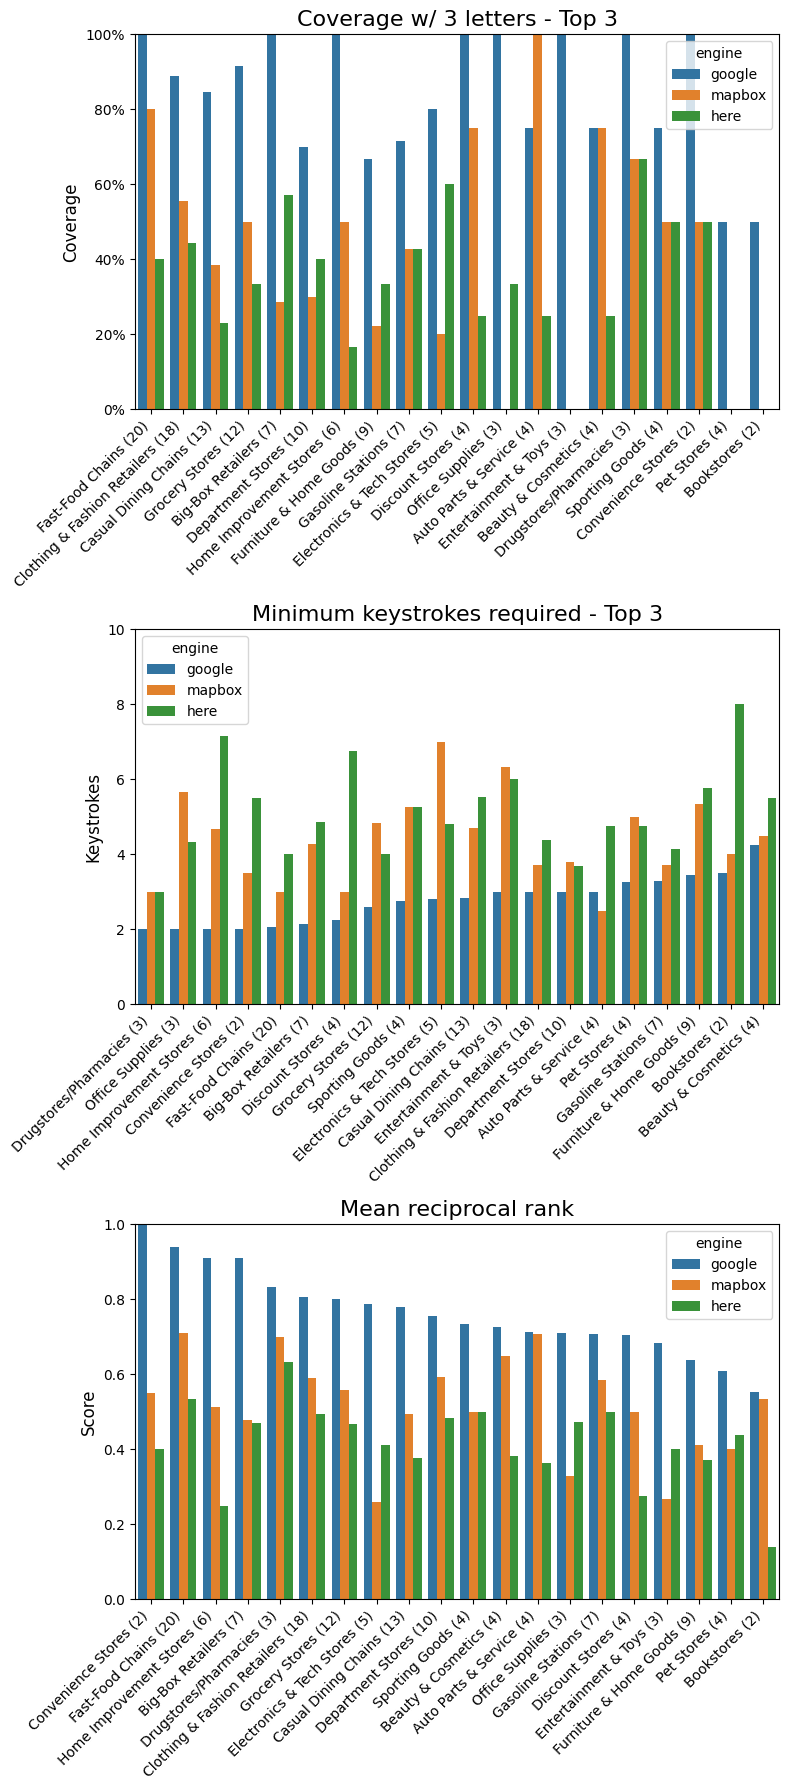

In [1357]:



fig, axes = plt.subplots(3, 1, figsize=(8, 18))


cov_ordering = metric_df.loc[metric_df['engine']=='google',['Category_n','cov_3_top3']].groupby('Category_n').sum().sort_values(by='cov_3_top3', ascending=False).index.to_list()
sns.barplot(x='Category_n', y='cov_3_top3',hue='engine', data=metric_df,ax=axes[0], errorbar=None, order = cov_ordering)

# Add labels and title
axes[0].set_title('Coverage w/ 3 letters - Top 3', fontsize=16)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('Coverage', fontsize=12)
axes[0].set_ylim(0,1)
axes[0].yaxis.set_major_formatter(PercentFormatter(1))
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')

mk_ordering = metric_df.loc[metric_df['engine']=='google',['Category_n','mk_top3']].groupby('Category_n').mean().sort_values(by='mk_top3').index.to_list()
sns.barplot(x='Category_n', y='mk_top3',hue='engine', data=metric_df,ax=axes[1], errorbar=None, order = mk_ordering)
# Add labels and title
axes[1].set_title('Minimum keystrokes required - Top 3', fontsize=16)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('Keystrokes', fontsize=12)
axes[1].set_ylim(0,10)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,ha='right')



mrr_ordering = metric_df.loc[metric_df['engine']=='google',['Category_n','mrr']].groupby('Category_n').mean().sort_values(by='mrr',ascending=False).index.to_list()
sns.barplot(x='Category_n', y='mrr',hue='engine', data=metric_df,ax=axes[2], errorbar=None, order = mrr_ordering)
# Add labels and title
axes[2].set_title('Mean reciprocal rank', fontsize=16)
axes[2].set_xlabel('', fontsize=12)
axes[2].set_ylabel('Score', fontsize=12)
axes[2].set_ylim(0,1)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=45,ha='right')

    
plt.tight_layout()
# Show the plot
plt.show()

In [1358]:
show(metric_df)

In [1395]:
show(autocomplete_df.loc[(autocomplete_df['query']=='chipotle mexican grill') & (autocomplete_df['engine'] == 'here') & (autocomplete_df['num_char'] == 3),:])